# Time Series Comparison Models (SARIMAX Vs LSTM Vs fbprophet)

## Main Objective

The aims of this report is to compare different time series algorithms (SAIMAX, fbprophet and LSTM ), As part of this study; These models will be used alongside with time series for forecasting purpose  to assess the pros and cons for each one of them
Note: This study has been by run by using Modest workstation (specs):  
**Intel(R) Core ™ - 5i 6400 CPU @ 2.7GHz  
RAM (8GB).**


## Benefits:

In general, all Data scientists can benefit from this report however beginner Data scientist who just started their learning journey can benefit more as this study provides enough adequate details on creating time series models from scratch and by using real dataset. In addition to that, normal users who do not have machine learning workstation equipped by powerful tools like GPU can also benefit from this report.

## Dataset

Source:
You can download the dataset from Kaggle website (https://www.kaggle.com/c/m5-forecasting-accuracy/data), the source of this data is https://mofc.unic.ac.cy/m5-competition/
Dataset has been lunched as part of The M5 Competition
About Dataset:
It used hierarchical sales data, generously made available by Walmart, starting at the item level and aggregating to that of departments, product categories and stores in three geographical areas of the US: California, Texas, and Wisconsin.

Besides the time series data, it also included explanatory variables such as price, promotions, day of the week, and special events (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter) that affect sales which are used to improve forecasting accuracy.


## Data Attribute:

Dataset contains  4 CSV sheets as shown beknow:
* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
* sell_prices.csv - Contains information about the price of the products sold per store and date.
* sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

Each training dataset has around 30490 rows and 1919 columns, each row represents product, and each column represents day (time series is daily frequency)  

Listing all columns is not right option because their number is so high, however and for sake of this report we will shed light on the following columns:
d_number of days columns which represent days number starting from d_1,d_2,d_3 …d_1913, there are 1913 days which equal to  5 years (End of 2011 to mid of 2016) and two months, type of column is ‘integer
  
In addition to train dataset, Calendar dataset will be used to convert days number to datetime type and to create holidays dataset for fbprophet model 


## Import Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import seaborn as sns
#import pmdarima as pm
from dateutil.relativedelta import relativedelta
import warnings
warnings.simplefilter(action='ignore')
from sklearn.metrics import accuracy_score
import time
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import fbprophet  # if you have an issue (on your workstation) with fbprophet on python3.8 i would suggest you to use python3.7 instead
from fbprophet import Prophet
from numpy import median
import math
import statistics

## Data cleaning / feature engineering

In [2]:
# reading and inserting the csv sheet into DataFrame
df = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
df.head(3)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [3]:
# No null cells!!
df.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [4]:
# reading and inserting the calendar csv sheet into Dataframe, this data will be used as lookup to get the right date for each day in df dataframe
calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
calendar.head(3)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


**Creating new Dataframe and set the datetime as index**

In [5]:
df.drop(columns=['item_id', 'dept_id','cat_id','store_id','state_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = df.T  # seting the days as index for new dataframe(Data)
data.columns = df['id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calendar['date'][0:1913]
data.index = pd.to_datetime(data.index)
data.index.freq= 'd'
data.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
               '2016-04-19', '2016-04-20', '2016-04-21', '2016-04-22',
               '2016-04-23', '2016-04-24'],
              dtype='datetime64[ns]', name='date', length=1913, freq='D')

**Since the number of products is so high we will focus on product with highest number of purchasments, Below code will get is this product** 

In [6]:
max_value =data.max().to_frame()
max_prod = max(data.max())
max_value.loc[max_value[0] == max_prod]

,0
id,
FOODS_3_090_CA_3_validation,763.0


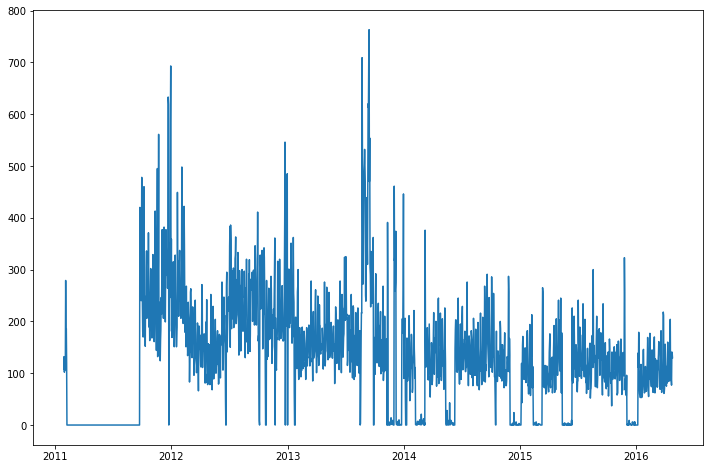

In [6]:
# WE noctice that numbe of purchasments is zero for arround first 10 months which looks justified if product was not linched or avaliable yet in the stores at that time thats why this interval will be ecluded from time series 
plt.figure(figsize=(12,8))
plt.plot(data.index,data['FOODS_3_090_CA_3_validation'])

**Observation:  
The first few montths have no data (mabye the product was not luanched at that time or not avaliable in the stores) so exclude these months is good approach**


***

**Checking the type of time series (stationary or non-statinary)**

***

adf is -4.173018148719144
pvalue is 0.0007317275745300179


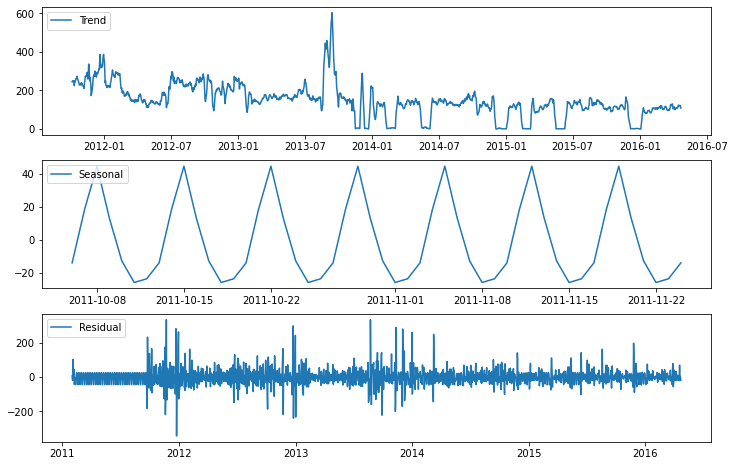

In [7]:
# Using the decompostion method...
ss_decomposition = seasonal_decompose(x=data['FOODS_3_090_CA_3_validation'])
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

#fig, ax = plt.subplots(3,1, figsize=(12,8))
fig, ax = plt.subplots(3,figsize=(12,8) )
#plt.figure(figsize=(12,5))
#plt.subplot(3,1,1)
ax[0].plot(data.index[250:],estimated_trend[250:], label='Trend')
ax[0].legend(loc='upper left')

#plt.subplot(3,1,2)
ax[1].plot(data.index[250:300],estimated_seasonal[250:300], label='Seasonal')
ax[1].legend(loc='upper left')

#plt.subplot(3,1,3)
ax[2].plot(data.index,estimated_residual, label='Residual')
ax[2].legend(loc='upper left')

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data['FOODS_3_090_CA_3_validation'])

print(f'adf is {adf}')
print(f'pvalue is {pvalue}')


**Observations:**
* p-value is **0.0007317275745300305** which is much less than .05 so we can reject the "null hypothesis" which says time series is not stationary
* Data has weekly sesonality
* Data does not have constant varaiance.

let us plot the acf and pacf as well

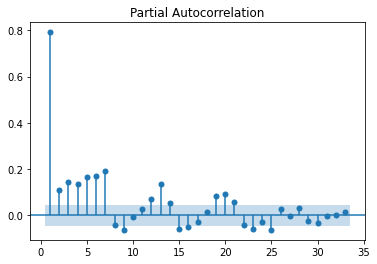

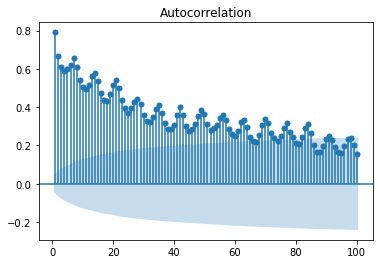

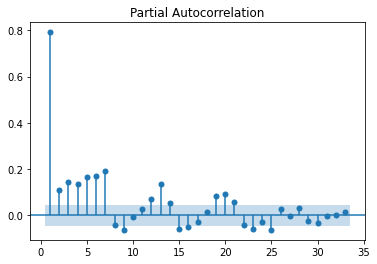

In [8]:
#plt.subplot(3,1,4)
plot_acf(data['FOODS_3_090_CA_3_validation'],lags=100, zero=False)


#plt.subplot(3,1,5)
plot_pacf(data['FOODS_3_090_CA_3_validation'], zero=False)

**Observations:**
* All significants lags in Partial Autocorrelation chart are positive and largest one is lag1 so we can tuning p parameter in range(0,3) and q in range(0,2).
* All significants lags in  Autocorrelation chart are positive and largest one is lag1 so we can tuning P parameter in range(0,3) and Q in range(0,2) in seasonal_orders

adf is -9.690404728774508
pvalue is 1.1405330819669683e-16


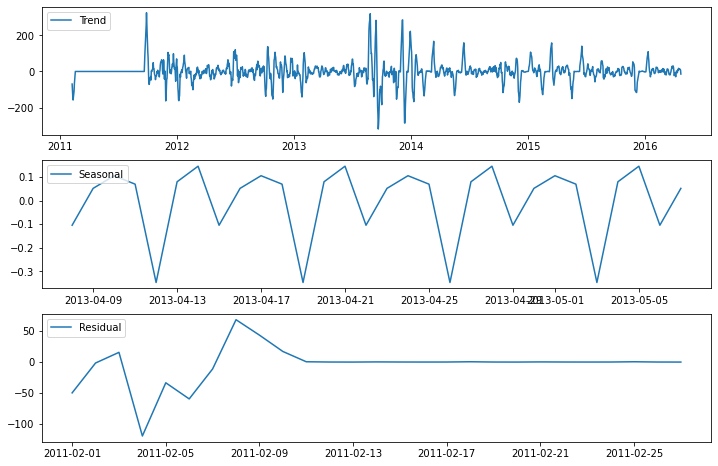

In [9]:
# diffrencing method

data['shift'] = data['FOODS_3_090_CA_3_validation'].shift(7)
data['week_lag'] = data['FOODS_3_090_CA_3_validation'] - data['shift']

ss_decomposition = seasonal_decompose(x=data['week_lag'].dropna())
lag_trend = ss_decomposition.trend
lag_seasonal = ss_decomposition.seasonal
lag_residual = ss_decomposition.resid

#fig, ax = plt.subplots(3,1, figsize=(12,8))
fig, ax = plt.subplots(3,figsize=(12,8) )
#plt.figure(figsize=(12,5))
#plt.subplot(3,1,1)
ax[0].plot(data.index[7:],lag_trend, label='Trend')
ax[0].legend(loc='upper left')

#plt.subplot(3,1,2)
ax[1].plot(data.index[800:830],lag_seasonal[800:830], label='Seasonal')
ax[1].legend(loc='upper left')

#plt.subplot(3,1,3)
ax[2].plot(data.index[:30],lag_residual[:30], label='Residual')
ax[2].legend(loc='upper left')

adf_dif, pvalue_dif,usedlag, nobs, critical_values, icbest = adfuller(data['week_lag'].dropna())

print(f'adf is {adf_dif}')
print(f'pvalue is {pvalue_dif}')


**Observation:**  
differencing has reduced the varaince as shown Trend plot after differencing with Trend plot befor differencing, so we expect value of d will be in range of(0,2)

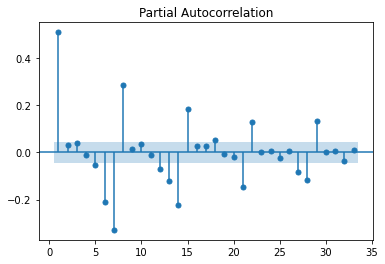

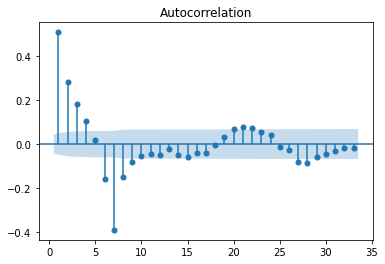

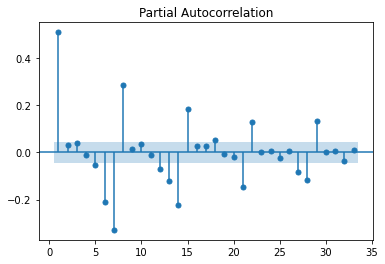

In [10]:
#plt.subplot(3,1,4)
plot_acf(data['week_lag'][7:],zero=False)


#plt.subplot(3,1,5)
plot_pacf(data['week_lag'][7:],zero=False)

## SARIMA MODEL

**Preparing the training and testing data for all models**

In [11]:
start_interval = 250 # removing the intial interval where no sold item data is shown
test_sample= 100
train_SARIMA = data['FOODS_3_090_CA_3_validation'][start_interval:-test_sample].astype('float')
test_SARIMA = train_SARIMA[-test_sample:].astype('float')
train_LSTM = data['FOODS_3_090_CA_3_validation'][start_interval:-2*test_sample].astype('float')
test_LSTM = data['FOODS_3_090_CA_3_validation'][-2*test_sample:-test_sample].astype('float')
train_prophet = data[['FOODS_3_090_CA_3_validation']][start_interval:-test_sample].astype('float')
true = data['FOODS_3_090_CA_3_validation'][-test_sample:].astype('float')
print('full data length', data[['FOODS_3_090_CA_3_validation']][start_interval:].shape)
print('train_SARIMA', train_SARIMA.shape)
print('test_SARIMA', test_SARIMA.shape)
print('train_LSTM', train_LSTM.shape)
print('test_LSTM', test_LSTM.shape)
print("train prophet", train_prophet.shape)
print("true ", true.shape)

full data length (1663, 1)
train_SARIMA (1563,)
test_SARIMA (100,)
train_LSTM (1463,)
test_LSTM (100,)
train prophet (1563, 1)
true  (100,)


**Tuning  hyparameter by using self developed method aims to reduce the number of iteration in order to enhance the performance of your workstation incase ready grid search tools do not run smoothly**

In [ ]:
# Custamized grid search


p_min,p_max = 0,3
d_min,d_max= 0,2
q_min,q_max = 0,2

P_min,P_max = 0,3
D_min, D_max = 0,2
Q_min,Q_max = 0,2

trend= 'n' # ['n','c','t','ct']
m=42

p_m = int(round(median([p_min,p_max]),0))
d_m = int(round(median([d_min,d_max]),0))
q_m = int(round(median([q_min,q_max]),0))
P_m = int(round(median([P_min,P_max]),0))
D_m = int(round(median([D_min,D_max]),0))          
Q_m = int(round(median([Q_min,Q_max]),0))          
          

start_time_init = time.time()
duppl_order = []

result = []

if (p_m,d_m,q_m) != (p_max,d_max,q_max):
    order = (p_m,q_m,d_m)
    seasonal_order = (P_m,D_m,Q_m,m)
    
    
    if order + seasonal_order in duppl_order:
        pass
    else:
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        rmse_m = math.sqrt(sum(pow((yhat - true),2))/len(true))
        result.append(({'order': (p_m,d_m,q_m),'seasonal_order': seasonal_order,'rmse':rmse_m}))
        duppl_order.append(order+seasonal_order)
        print(order,seasonal_order,'rmse_(p_m,q_m,d_m):', rmse_m)

    
    order = (p_max,d_max,q_max)
    if order + seasonal_order in duppl_order:
        pass
    else:
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        rmse_max = math.sqrt(sum(pow((yhat - true),2))/len(true))
        result.append(({'order': (p_max,d_max,q_max),'seasonal_order': seasonal_order,'rmse':rmse_max}))
        duppl_order.append(order+seasonal_order)
        print(order,seasonal_order,'rmse_(p_max,d_max,q_max):',rmse_max)

    order = (p_min,d_min,q_min)
    if order + seasonal_order in duppl_order:
        pass
    else:
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        rmse_min = math.sqrt(sum(pow((yhat - true),2))/len(true))
        result.append(({'order': (p_min,q_min,d_min),'seasonal_order': seasonal_order,'rmse':rmse_min}))
        duppl_order.append(order+seasonal_order)
        print(order,seasonal_order,'rmse_(p_min,d_min,q_min):',rmse_min)
    
   
    if rmse_max < rmse_min:
        p_loop = range(p_m,p_max)
        d_loop = range(d_m,d_max)
        q_loop = range(q_m,q_max)
    else:
        p_loop = range(p_min,p_m)
        d_loop = range(d_min,d_m)
        q_loop = range(q_min,q_m)
        
        
    for p_ in p_loop:
        for d_ in d_loop:
            for q_ in q_loop:
                start_time = time.time()
                order=(p_,d_,q_)
                seasonal_order = (P_m,D_m,Q_m,m)
                if order + seasonal_order in duppl_order:
                    pass
                else:
                    model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
                    yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
                    rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
                    result.append(({'order':order,'seasonal_order':seasonal_order,'rmse':rmse}))
                    duppl_order.append(order+seasonal_order)
                    duration = time.time() - start_time
                    print(order,seasonal_order,'rmse:' ,rmse , 'duration:',duration)
                    
    output = pd.DataFrame(result)
    fit_model = output[output['rmse'] == (output['rmse'].min())]
    order_fit = fit_model.order.values[0]
    
    
    if (P_m,D_m,Q_m) != (P_max,D_max,Q_max):
        order = order_fit
        seasonal_order = (P_m,D_m,Q_m,m)
        
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_m = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_m,D_m,Q_m,m),'rmse':Rmse_m}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_m,D_m,Q_m,m):', Rmse_m)
        
        seasonal_order = (P_max,D_Max,Q_Max,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_max = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_max,D_max,Q_max,m),'rmse':Rmse_max}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_max,D_max,Q_max,m):',Rmse_max)
        
        seasonal_order = (P_min,D_min,Q_min,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_min = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_min,D_min,Q_min,m),'rmse':Rmse_min}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_min,D_min,Q_min,m):',Rmse_min)

        
        if rmse_max < rmse_min:
            P_loop = range(P_m,P_max)
            D_loop = range(D_m,D_max)
            Q_loop = range(Q_m,Q_max)
        else:
            P_loop = range(P_min,P_m)
            D_loop = range(D_min,D_m)
            Q_loop = range(Q_min,Q_m)
        
        
        for P_ in P_loop:
            for D_ in D_loop:
                for Q_ in Q_loop:
                    start_time = time.time()
                    order = order_fit
                    seasonal_order = (P_,D_,Q_,m)
                    if order + seasonal_order in duppl_order:
                        pass
                    else:
                        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order= seasonal_order, trend='n').fit()
                        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
                        rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
                        result.append(({'order':order_fit,'seasonal_order':(P_,D_,Q_,m),'rmse':rmse}))
                        duppl_order.append(order+seasonal_order)
                        duration = time.time() - start_time
                        print(order,(P_,D_,Q_,m),'rmse:' ,rmse , 'duration:',duration)
        output2 = pd.DataFrame(result)
        fit_model2 = output2[output2['rmse'] == (output2['rmse'].min())]
        print('best model: ',fit_model2.order.values,fit_model2.seasonal_order.values, 'rmse:', fit_model2.rmse.values)
    
    
    else:
        order = order_fit
        seasonal_order_best = (P_m,D_m,Q_m,m)
        
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order,'seasonal_order': seasonal_order,'rmse':rmse}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'rmse:',rmse)

else:
    order = (p_m,q_m,d_m)
    if (P_m,D_m,Q_m) != (P_max,D_max,Q_max):
        
        
        seasonal_order = (P_m,D_m,Q_m,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order= seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_m = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_m,D_m,Q_m,m),'rmse':Rmse_m}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_m,D_m,Q_m,m):', Rmse_m)
        
        seasonal_order =  (P_max,D_max,Q_max,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_max = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_max,D_max,Q_max,m),'rmse':Rmse_max}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_max,D_max,Q_max,m):',Rmse_max)
            
        seasonal_order = (P_min,D_min,Q_min,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order= seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_min = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_min,D_min,Q_min,m),'rmse':Rmse_min}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_min,D_min,Q_min,m):',Rmse_min)
        
        
            
        if rmse_max < rmse_min:
            P_loop = range(P_m,P_max)
            D_loop = range(D_m,D_max)
            Q_loop = range(Q_m,Q_max)
            
        else:
            P_loop = range(P_min,P_m)
            D_loop = range(D_min,D_m)
            Q_loop = range(Q_min,Q_m)
            
        
        for P_ in P_loop:
            for D_ in D_loop:
                for Q_ in Q_loop:
                    start_time = time.time()
                    
                    seasonal_order = (P_,D_,Q_,m)
                    if order + seasonal_order in duppl_order:
                        pass
                    else:
                        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order= seasonal_order, trend='n').fit()
                        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
                        rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
                        result.append(({'order':order_fit,'seasonal_order':(P_,D_,Q_,m),'rmse':rmse}))
                        duppl_order.append(order+seasonal_order)
                        duration = time.time() - start_time
                        print(order,(P_,D_,Q_,m),'rmse:' ,rmse , 'duration:',duration)
        
        
        output2 = pd.DataFrame(result)
        fit_model2 = output2[output2['rmse'] == (output2['rmse'].min())]
        print('best model: ',fit_model2.order.values,fit_model2.seasonal_order.values, 'rmse:', fit_model2.rmse.values)
        
    else:
        seasonal_order = (P_m,D_m,Q_m,m)
        
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order,'seasonal_order': seasonal_order,'rmse':rmse}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'rmse:',rmse)
 
duration = time.time() - start_time_init

print('Full total time: ',duration)

**Building and fitting SARIMX model**

In [12]:
start_time = time.time()
seasonal_order = (2, 1, 1, 42)
order_m = (2,1,1)
model_sarima = sm.tsa.statespace.SARIMAX(train_SARIMA, order=order_m, seasonal_order=seasonal_order, trend='n').fit()
duration = (time.time() - start_time) / 60
print(f'training is done within:{duration} minutes')

training is done within:4.880496668815613 minutes


In [13]:
# out of sample prediction for (100 days):
yhat_sarima = model_sarima.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True)

**Calculating the rmse for SARIMX model for 100 days,The rmse trend going up as forcasting days increases**

In [45]:
sarimax_Rmse = []
for i in np.arange(10,100,10):
    sarimax_Rmse.append(math.sqrt(sum(pow((yhat_sarima[:i] - true[:i]),2))/len(true[:i])))
sarimax_Rmse

[29.688781379057353,
 28.29074805458952,
 33.7352885135893,
 34.4672036246645,
 41.923309997922495,
 44.08178032767389,
 44.20364698491651,
 46.76459949852436,
 47.68326521289093]

In [13]:
future_fcst = model_sarima.get_forecast(100)
# That will have a method to pull in confidence interval 
confidence_int = future_fcst.conf_int(alpha = 0.01)
confidence_int['yhat'] = abs(confidence_int['lower FOODS_3_090_CA_3_validation'] + confidence_int['upper FOODS_3_090_CA_3_validation']/2)
confidence_int

,lower FOODS_3_090_CA_3_validation,upper FOODS_3_090_CA_3_validation,yhat
2016-01-16,-65.157988,265.822440,67.753231
2016-01-17,-117.318716,258.018994,11.690781
2016-01-18,-144.255239,249.377063,19.566708
2016-01-19,-154.444819,250.601627,29.144005
2016-01-20,-167.848531,246.295089,44.700986
...,...,...,...
2016-04-20,-437.918473,504.787052,185.524947
2016-04-21,-432.366053,515.585672,174.573217
2016-04-22,-391.193562,561.975460,110.205832
2016-04-23,-361.795308,596.562598,63.514009


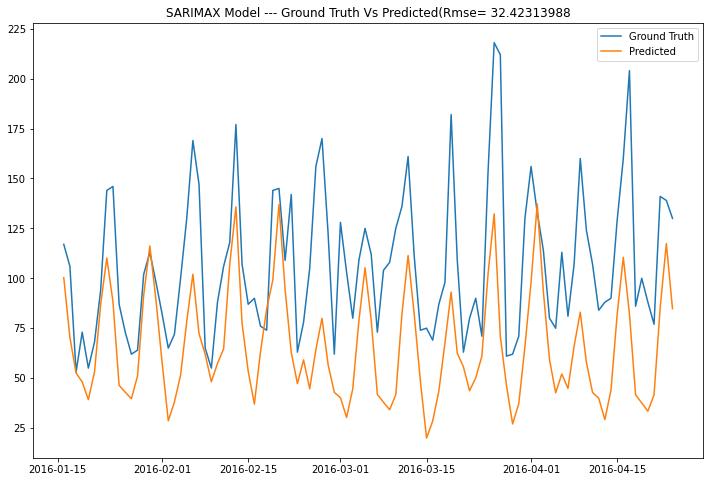

In [16]:
plt.figure(figsize=(12,8))
plt.plot(true, label='Ground Truth')
plt.plot(yhat_sarima, label='Predicted')
plt.title('SARIMAX Model --- Ground Truth Vs Predicted(Rmse= 32.42313988')


plt.legend()

**Plot the diagnostics**

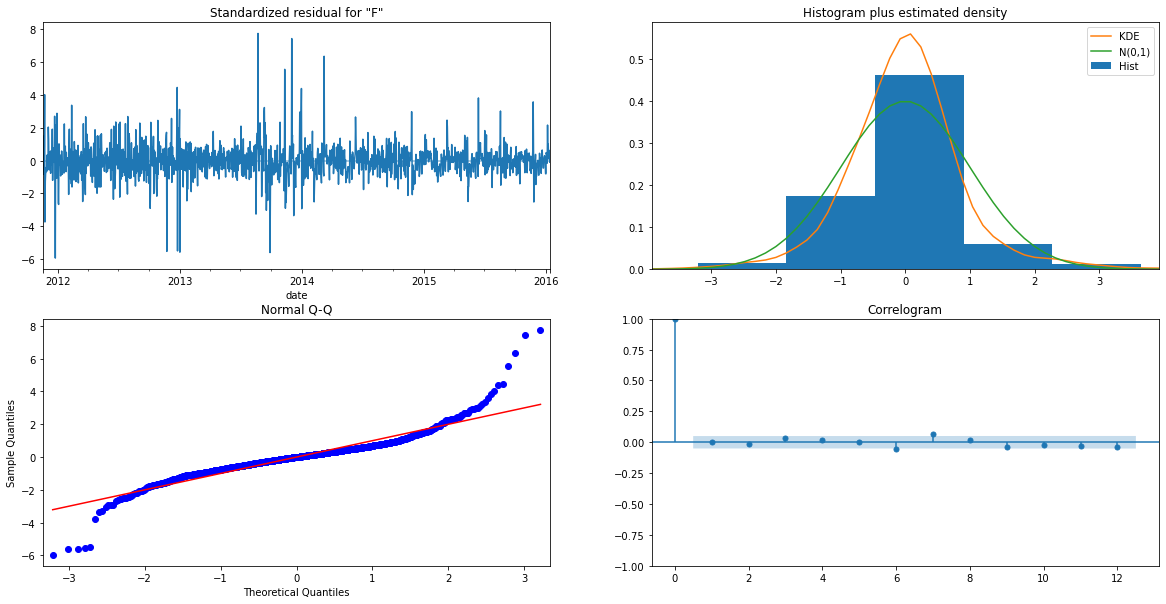

In [16]:
model_sarima.plot_diagnostics(lags=12,figsize = (20,10),);

**Observation:**
* Histogrham and estimated density: We  see green and orange lines are close and having the same shape which is good indicator that our model has fit the data properly
* Correlogram: We See that correlation is not significant of course except at lag0 which normal as any data is 100 correlated with itself.
* Normal Q-Q: We see that red line overlap most of blue dots which is good indiactor.


## LSMT Model

In [17]:
# Create x_train,y_train for LSTM model

input_days = 12
x_train, y_train = [],[]
for i in range(0,train_LSTM.shape[0] - input_days,3):
    x_train.append(train_LSTM[i:i+input_days])
    y_train.append(train_LSTM[i+input_days])

    
x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
y_train = np.asarray(y_train)
print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)

x_train shape (484, 12, 1)
y_train shape (484,)


In [ ]:
# building simple LSMT model:

start_time = time.time()
cell_units = 1000
epochs = 1500

model_LSTM = Sequential() 

model_LSTM.add(LSTM(cell_units,input_shape=(x_train.shape[1],1))) #return_sequences= True))
    

model_LSTM.add(Dense(1))
    

model_LSTM.compile(loss='mean_squared_error', optimizer='adam')
model_LSTM.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1)


duration = (time.time() - start_time) / 60
print(f'training is done within:{duration} minutes')

In [19]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1000)              4008000   
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 4,009,001
Trainable params: 4,009,001
Non-trainable params: 0
_________________________________________________________________


***

**Forcasting (LSTM model)**

***

In [20]:
# Creating x_test data (its shape should be match with training data and with input_shape)
x_test = []
for i in range(0,test_LSTM.shape[0] - input_days + 1):
    x_test.append(test_LSTM[i:i + input_days])
               
x_test = np.asarray(x_test)    
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print('x_test shape', x_test.shape)


x_test shape (89, 12, 1)


In [21]:
# prediction function which goes through each row where each row contains 12 data cells and each cell value will be replaced by predicted value...
pred = []

for i in range(x_test.shape[0]):
    for _ in range(x_test.shape[1]):
        prediction = model_LSTM.predict(x_test[i:i+1,:,:])
        pred.append(prediction)
        x_test[i,:-1,:] = x_test[i,1:,:]
        x_test[i,-1,:] = prediction

In [22]:
# Reshape the output of precidiction array from (89,12,1) shape to (100,) shape (input_days = 12)
yhat_lstm = np.arange(0,100,1,'float')
y_flatten = x_test.flatten()
yhat_lstm[:input_days] = y_flatten[:input_days] # 
k = 2
for i in range(input_days,test_LSTM.shape[0]):
    yhat_lstm[i] = y_flatten[(k*input_days) - 1]  # {formula:2*input_days - 1}
    k +=1
    
lstm_result = pd.DataFrame(data=yhat_lstm, index=true.index, columns=['yhat'])
lstm_result['true'] = true

**Residual for LSTM**

In [43]:
lstm_Rmse = []

for i in np.arange(10,100,10):
    lstm_rmse = math.sqrt(sum(pow((lstm_result['yhat'][:i] - true[:i]),2))/len(true[:i]))
    lstm_Rmse.append(lstm_rmse)
lstm_Rmse



[62.17464834898333,
 52.85521436271776,
 58.81185115918548,
 59.35944509200073,
 59.83445864825173,
 59.29936977404308,
 59.197216448986396,
 59.64941677854252,
 62.676274086650274]

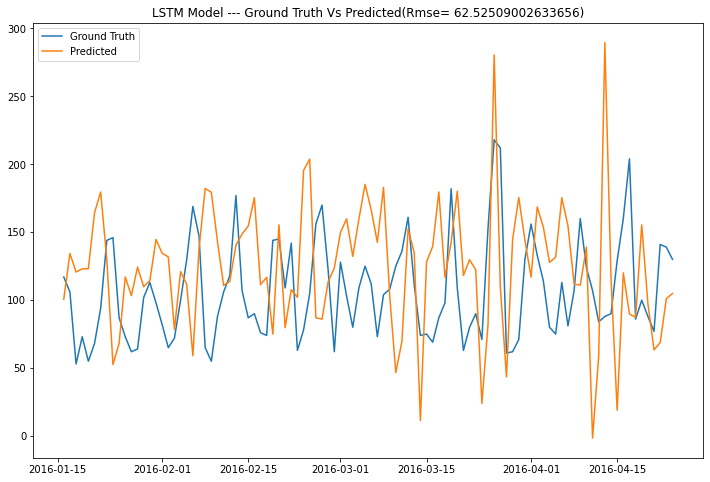

In [24]:
plt.figure(figsize=(12,8))
plt.plot(true, label='Ground Truth')
plt.plot(lstm_result.yhat, label='Predicted')
plt.title('LSTM Model --- Ground Truth Vs Predicted(Rmse= {})'.format(lstm_rmse))
plt.legend()

## fbprophet Model

In [25]:
# prepare dataframe for fprophet model
train_prophet['ds'] = train_prophet.index.values
train_prophet.rename(columns={'FOODS_3_090_CA_3_validation':'y'},inplace=True)
train_prophet = train_prophet[['ds','y']]
train_prophet.columns.name = None
train_prophet

,ds,y
date,,
2011-10-06,2011-10-06,249.0
2011-10-07,2011-10-07,254.0
2011-10-08,2011-10-08,460.0
2011-10-09,2011-10-09,170.0
2011-10-10,2011-10-10,229.0
...,...,...
2016-01-11,2016-01-11,68.0
2016-01-12,2016-01-12,59.0
2016-01-13,2016-01-13,94.0


training is done within:4.0812835693359375 minutes


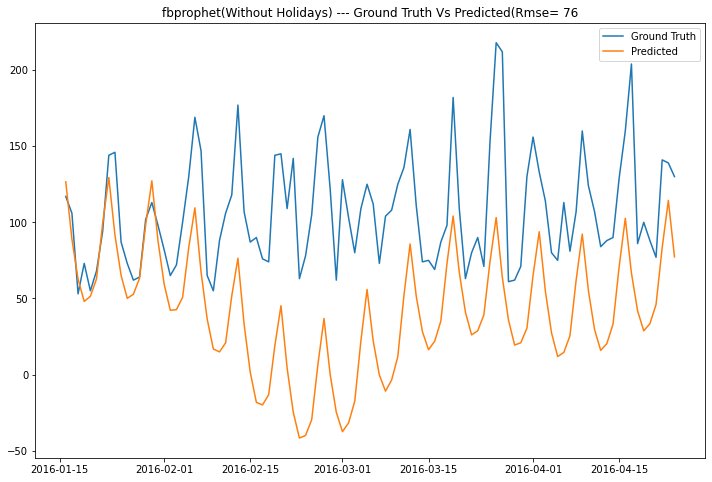

In [26]:
#fprophet model without holidays
start_time = time.time()
m = Prophet(weekly_seasonality=True)
m.fit(train_prophet)

future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)
predicted_prophet = forecast[['yhat']][-test_sample:]
predicted_prophet.set_index(true.index,inplace=True)
predicted_prophet.index

duration = time.time() - start_time
print(f'training is done within:{duration} minutes')


plt.figure(figsize=(12,8))
plt.plot(true, label='Ground Truth')
plt.plot(predicted_prophet, label='Predicted')
plt.title('fbprophet(Without Holidays) --- Ground Truth Vs Predicted(Rmse= 76')
plt.legend()

In [27]:
#fprophet model with holidays

holidays = calendar[calendar['event_type_1'].isnull() == False]
holidays = holidays[['date','event_name_1', 'event_type_1']]
holidays.rename(columns={'date':'ds','event_name_1':'holiday'},inplace=True)

start_time = time.time()

m_holi = Prophet(weekly_seasonality=True,holidays=holidays)
m_holi.fit(train_prophet)

future = m_holi.make_future_dataframe(periods=100)
forecast = m_holi.predict(future)
predicted_prophet = forecast[['yhat']][-test_sample:]
predicted_prophet.set_index(true.index,inplace=True)
predicted_prophet.index

print(f'training is done within:{duration} minutes')



training is done within:4.0812835693359375 minutes


**fbprophet Residual**

In [42]:
prophet_Rmse = []
for i in np.arange(10,100,10):
    prophet_rmse = math.sqrt(sum(pow((predicted_prophet.yhat[:i] - true[:i]),2))/len(true[:i]))
    prophet_Rmse.append(prophet_rmse)
prophet_Rmse

[23.912905732564404,
 24.01517243909483,
 44.07209660270271,
 65.6974302447992,
 79.75649553366466,
 80.84491338960707,
 77.11078682173546,
 76.3784306087999,
 75.30203185214124]

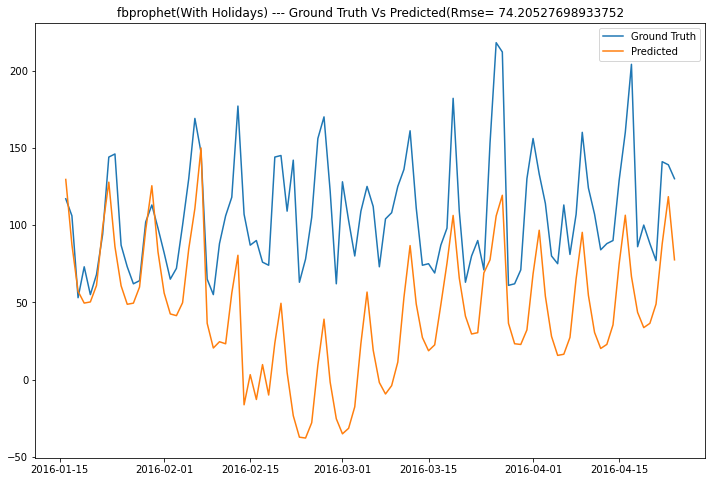

In [29]:
plt.figure(figsize=(12,8))
plt.plot(true, label='Ground Truth')
plt.plot(predicted_prophet, label='Predicted')
plt.title('fbprophet(With Holidays) --- Ground Truth Vs Predicted(Rmse= {}'.format(prophet_rmse))
plt.legend()

## Recomended Model

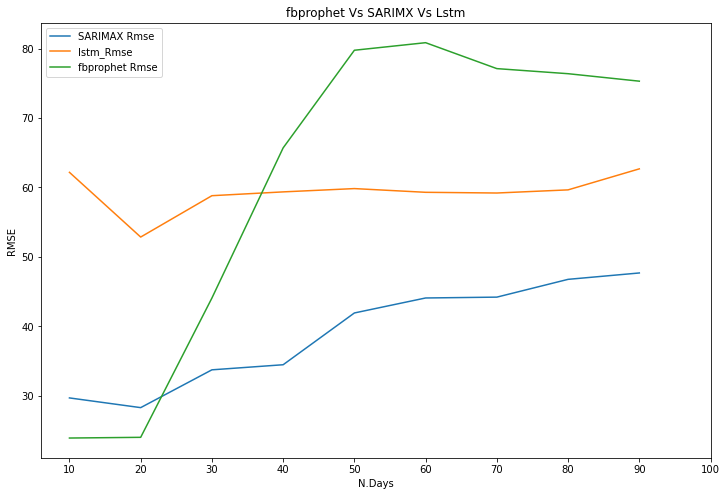

In [49]:
plt.figure(figsize=(12,8))
plt.plot(sarimax_Rmse, label='SARIMAX Rmse')
plt.plot(lstm_Rmse, label='lstm_Rmse')
plt.plot(prophet_Rmse, label='fbprophet Rmse')
plt.ylabel('RMSE')
plt.xlabel('N.Days')
plt.title('fbprophet Vs SARIMX Vs Lstm')
plt.xticks(np.arange(10), ['10', '20', '30','40', '50', '60','70', '80', '90','100'])
plt.legend()

**Observation**  

* Accuracy of fbprophet for first 10 days is the best, but after then the SARIMAX defeats fbprophet.
* Accuracy of LSTM comes in the middle between SARIMAX and fbprophet and it does not drop.

| Model | Training Time (Minutes) }
| --- | --- |
| SARIMAX | 5.8 |
| fbprophet | 3.0 |
| LSTM | 35.0* , 1.7** |
*(By using CPU only)
**(By using GPU)

* SARIMAX model residual is the lowest one and the shape of the predicted values is best match the shape of actual values,So SARIMAX model will be the recommended model consedering its more open for enhancement via tune hyperparameter, the only limitation comes from hardware requirments since powerful workstation is high requiered to perform grid searching . 

* Fbprophet will be good option if short term forecasting is required (let us say period of two weeks ), its training time is the lowest and does not need powerful workstation, so its good choice especially if number of time series which need to be forecasted is high,Its performance and ability to fitech the seasonality give its good credit.

* LSTM model could be also selected if dataset is big enough as it can get the pattern properly but ؤertainly would require powerful workstation equipped with  GPU and high RAM as well .

